In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

seed = 10
train_size = 18000
val_size = 5000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)

cuda
2.5.1+cu121


In [2]:
dataset = load_dataset("squad_v2")
train_data = dataset["train"].shuffle(seed = seed).select(range(train_size))
val_data = dataset["validation"].shuffle(seed = seed).select(range(val_size))

tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-large-cased")

def preprocess(data):
    inputs = tokenizer(
        data["question"],
        data["context"],
        truncation = True,
        padding = "max_length",
        max_length = 512,
        stride = 128,
        return_overflowing_tokens = True,
        return_offsets_mapping = True
    )
    
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    
    start_positions, end_positions = [], []
    
    for i, offsets in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = data["answers"][sample_idx]
        
        if len(answer["text"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
        else:
            start_char = answer["answer_start"][0]
            end_char = start_char + len(answer["text"][0])
            
            token_start_index = next((idx for idx, (start, end) in enumerate(offsets) if start_char >= start and start_char < end), 0)
            token_end_index = next((idx for idx, (start, end) in enumerate(offsets) if end_char > start and end_char <= end), 0)
            
            start_positions.append(token_start_index)
            end_positions.append(token_end_index)
    
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    inputs["overflow_to_sample_mapping"] = sample_map
    
    return inputs


tokenized_train_data = train_data.map(preprocess, batched=True, remove_columns=train_data.column_names)
tokenized_val_data = val_data.map(preprocess, batched=True, remove_columns=val_data.column_names)

tokenized_train_data.set_format(type="torch", device=device)
tokenized_val_data.set_format(type="torch", device=device)

README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [3]:
model = AutoModelForQuestionAnswering.from_pretrained("SpanBERT/spanbert-large-cased").to(device)

training_args = TrainingArguments(
    output_dir = "/kaggle/working/spanbert_model",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    learning_rate = 3e-5,
    num_train_epochs = 8,
    weight_decay = 0.01,
    logging_dir = "/kaggle/working/logs",
    logging_steps = 500,
    save_total_limit = 2,
    report_to = "none",
    fp16 = True
)


def extract_answer(start_logits, end_logits, input_ids):
    """Extracts the best answer span based on softmax probability."""
    start_probs = torch.softmax(torch.tensor(start_logits), dim=-1).numpy()
    end_probs = torch.softmax(torch.tensor(end_logits), dim=-1).numpy()

    best_start, best_end = 0, 0
    max_prob = 0

    for i in range(len(start_probs)):
        for j in range(i, min(i + 30, len(end_probs))):
            prob = start_probs[i] * end_probs[j]
            if prob > max_prob:
                best_start, best_end = i, j
                max_prob = prob

    predicted_answer = tokenizer.decode(input_ids[best_start:best_end + 1], skip_special_tokens=True)
    return predicted_answer

def exact_match_score(predictions, references):
    """Computes the exact match (EM) score between predictions and references."""
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100  # Convert to percentage

def compute_metrics(eval_pred):
    """Computes exact match (EM) for evaluation."""
    start_logits, end_logits = eval_pred.predictions

    sample_map = tokenized_val_data["overflow_to_sample_mapping"]
    
    predictions = []
    references = []

    for i, (start, end, input_ids) in enumerate(zip(start_logits, end_logits, tokenized_val_data["input_ids"])):
        sample_idx = sample_map[i]
        
        if sample_idx >= len(val_data["answers"]):
            continue
        
        pred_text = extract_answer(start, end, input_ids)
        ref_text = val_data["answers"][sample_idx]["text"][0] if val_data["answers"][sample_idx]["text"] else ""

        predictions.append(pred_text)
        references.append(ref_text)

    em_score = exact_match_score(predictions, references)
    return {"exact_match": em_score}

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train_data,
    eval_dataset = tokenized_val_data,
    processing_class = tokenizer,
    compute_metrics = compute_metrics
)

pytorch_model.bin:   0%|          | 0.00/665M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [4]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Exact Match
1,1.737500,1.642858,21.203722
2,1.279500,1.614799,29.023956
3,0.717100,1.213210,27.024352
4,0.505900,1.494799,27.162938
5,0.347300,1.566618,30.726589
6,0.239900,1.898837,26.608592
7,0.167600,2.056581,30.310830
8,0.110600,2.379298,29.934666


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=9040, training_loss=0.6810851167788547, metrics={'train_runtime': 39889.8815, 'train_samples_per_second': 3.625, 'train_steps_per_second': 0.227, 'total_flos': 1.3427617174983475e+17, 'train_loss': 0.6810851167788547, 'epoch': 8.0})

In [5]:
with torch.no_grad():
    eval_results = trainer.evaluate()


print(f"Evaluation Results: {eval_results}")

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results: {'eval_loss': 2.379298448562622, 'eval_exact_match': 29.934666402692535, 'eval_runtime': 1443.264, 'eval_samples_per_second': 3.5, 'eval_steps_per_second': 0.219, 'epoch': 8.0}


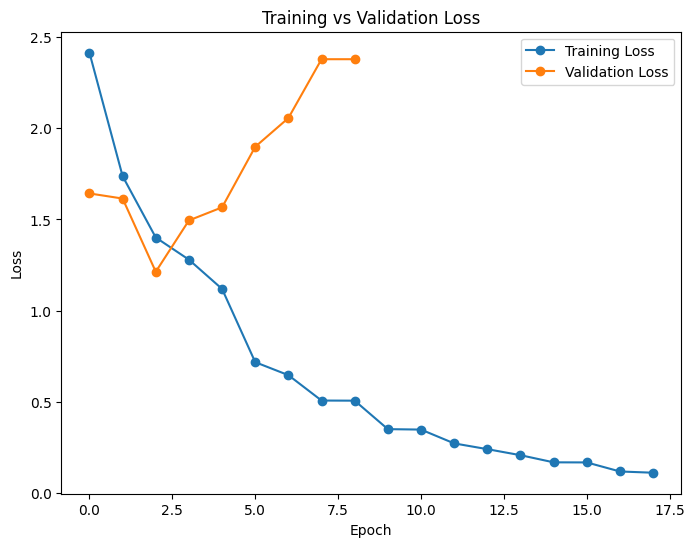

In [6]:
logs = trainer.state.log_history

train_loss = [entry["loss"] for entry in logs if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="Training Loss", marker="o")
plt.plot(eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [7]:
model.save_pretrained("/kaggle/working")
tokenizer.save_pretrained("/kaggle/working")

('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/vocab.txt',
 '/kaggle/working/added_tokens.json',
 '/kaggle/working/tokenizer.json')